In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import TensorDataset, DataLoader

# 1. Đọc và xử lý dữ liệu gốc
df = pd.read_csv('BITCOIN24.csv')  # Thay bằng file của bạn
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Giữ các cột cần thiết
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].copy()

# Kiểm tra missing values
print("Missing values:\n", df.isnull().sum())
df = df.dropna()  # hoặc fill nếu cần

Missing values:
 Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


/var/folders/8d/lh13mtcs1d53jwg6vx38f68m0000gn/T/ipykernel_15908/2345494822.py:9: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])


In [ ]:
# 2. Tạo các đặc trưng mới 
'''
Mục đích chính của MA là "làm mượt" biến động giá bằng cách loại bỏ các "nhiễu" (những đợt giá giật lên xuống bất thường trong ngắn hạn).
Điều này giúp nhà đầu tư nhìn thấy xu hướng (Trend) rõ ràng hơn:
Nếu giá nằm trên đường MA: Xu hướng tăng (Uptrend).
Nếu giá nằm dưới đường MA: Xu hướng giảm (Downtrend)
'''

# Lag features (Close_t-1, Close_t-2, ..., Close_t-10)
lag_days = 10
for i in range(1, lag_days + 1):
    df[f'Close_lag_{i}'] = df['Close'].shift(i)

# Technical indicators
# Moving Averages
df['MA_5'] = df['Close'].rolling(window=5).mean()#Trung bình 5 ngày
df['MA_10'] = df['Close'].rolling(window=10).mean()
df['MA_20'] = df['Close'].rolling(window=20).mean()

In [ ]:
# RSI (Relative Strength Index) - 14 ngày
'''
RSI (Relative Strength Index - Chỉ số sức mạnh tương đối) là chỉ báo kỹ thuật đo lường tốc độ và mức độ thay đổi giá của tài sản
tài chính, giúp nhà đầu tư xác định trạng thái quá mua (trên 70) hoặc quá bán (dưới 30)
Vùng quá mua: Khi RSI > 70, cho thấy tài sản có thể bị mua quá mức và có khả năng điều chỉnh giảm.
Vùng quá bán: Khi RSI < 30, cho thấy tài sản có thể bị bán quá mức và có khả năng hồi phục tăng giá.
'''
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI_14'] = 100 - (100 / (1 + rs))
df.dropna(inplace=True)


In [ ]:
# MACD
'''
* Nếu MACD > 0: Đường ngắn hạn đang nằm trên đường dài hạn -> Giá đang tăng tốc (Đà tăng mạnh).
Nếu MACD < 0: Đường ngắn hạn nằm dưới đường dài hạn -> Giá đang rơi nhanh (Đà giảm mạnh).
EMA formula: Xu hướng đầu tư
Đường Tín Hiệu (Signal Line) của chỉ báo MACD là một đường trung bình động hàm mũ (EMA) 9 kỳ của chính đường MACD (MACD Line) và 
đóng vai trò như một bộ lọc nhiễu, xác nhận tín hiệu động lượng và xu hướng; khi MACD Line cắt lên trên đường Tín Hiệu (tín hiệu mua), 
hoặc cắt xuống dưới (tín hiệu bán), nó chỉ báo sự thay đổi trong sức mạnh và hướng đi của xu hướng thị trường. 
'''
ema_12 = df['Close'].ewm(span=12, adjust=False).mean()#Xu hướng ngắn hạn trong 13 ngày
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()#Xu hướng dài hạn
df['MACD'] = ema_12 - ema_26
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

In [26]:
# Liquidity proxy metrics (điểm nhấn của paper)
epsilon = 1e-8  # tránh chia cho 0

# Volume-to-Volatility Ratio (VVR)
df['Price_Range'] = df['High'] - df['Low']
df['VVR'] = df['Volume'] / (df['Price_Range'] + epsilon)

In [27]:
# Volume-Weighted Average Price (VWAP)
df['Typical_Price'] = (df['High'] + df['Low'] + df['Close']) / 3
df['PV'] = df['Typical_Price'] * df['Volume']
df['VWAP'] = df['PV'].rolling(window=1).sum() / (df['Volume'].rolling(window=1).sum() + epsilon)
#VWAP cumulative (như intraday), dùng cumsum(), nhưng với daily thì rolling(1) là giá trung bình ngày

In [28]:
# Xóa các hàng có NaN do shift/rolling
df_clean = df.dropna().reset_index(drop=True)

print(f"Số mẫu sau khi tạo features: {len(df_clean)}")
print("Các cột cuối cùng:", df_clean.columns.tolist())

Số mẫu sau khi tạo features: 2231
Các cột cuối cùng: ['Open', 'High', 'Low', 'Close', 'Volume', 'Date', 'Close_lag_1', 'Close_lag_2', 'Close_lag_3', 'Close_lag_4', 'Close_lag_5', 'Close_lag_6', 'Close_lag_7', 'Close_lag_8', 'Close_lag_9', 'Close_lag_10', 'MA_5', 'MA_10', 'MA_20', 'RSI_14', 'MACD', 'MACD_signal', 'Price_Range', 'VVR', 'Typical_Price', 'PV', 'VWAP']


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2231 entries, 19 to 2249
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Open           2231 non-null   float64       
 1   High           2231 non-null   float64       
 2   Low            2231 non-null   float64       
 3   Close          2231 non-null   float64       
 4   Volume         2231 non-null   float64       
 5   Date           2231 non-null   datetime64[ns]
 6   Close_lag_1    2231 non-null   float64       
 7   Close_lag_2    2231 non-null   float64       
 8   Close_lag_3    2231 non-null   float64       
 9   Close_lag_4    2231 non-null   float64       
 10  Close_lag_5    2231 non-null   float64       
 11  Close_lag_6    2231 non-null   float64       
 12  Close_lag_7    2231 non-null   float64       
 13  Close_lag_8    2231 non-null   float64       
 14  Close_lag_9    2231 non-null   float64       
 15  Close_lag_10   2231 non-n

In [30]:
df.describe()

,Open,High,Low,Close,Volume,Date,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_4,...,MA_10,MA_20,RSI_14,MACD,MACD_signal,Price_Range,VVR,Typical_Price,PV,VWAP
count,2231.000000,2231.000000,2231.000000,2231.000000,2.231000e+03,2231,2231.000000,2231.000000,2231.000000,2231.000000,...,2231.000000,2231.000000,2231.000000,2231.000000,2231.000000,2231.000000,2.231000e+03,2231.000000,2.231000e+03,2231.000000
mean,22410.940636,22919.069166,21877.424839,22434.379570,4.271589e+10,2021-02-08 00:00:00.000000256,22411.430452,22390.836198,22371.528017,22354.511424,...,22348.466595,22265.881030,52.147446,115.021170,110.647578,1041.644327,3.798177e+14,22410.291191,1.378181e+15,22410.291191
min,3239.810072,3269.710130,3188.542617,3236.700910,2.039620e+09,2018-01-20 00:00:00,3236.700910,3236.700910,3236.700910,3236.700910,...,3386.197279,3514.033766,5.009460,-5052.670656,-4449.193421,0.000000,2.730361e+06,3234.372891,7.524385e+12,3234.372891
25%,8377.402598,8618.658339,8169.117442,8386.238178,1.602536e+10,2019-07-31 12:00:00,8386.238178,8386.238178,8386.238178,8386.238178,...,8424.892339,8420.284754,38.584338,-332.386978,-310.596982,256.504726,2.809481e+07,8424.331069,1.405179e+14,8424.331069
50%,18673.990470,19206.101400,18042.082970,18770.202100,3.527576e+10,2021-02-08 00:00:00,18737.192660,18709.057380,18641.285030,18569.987700,...,18610.713122,18564.068627,51.755876,-1.999470,-14.732107,593.856230,4.949811e+07,18858.696227,7.266678e+14,18858.696227
75%,34684.564895,35597.374685,33629.515590,34782.356120,6.246996e+10,2022-08-19 12:00:00,34714.166565,34674.166565,34615.190590,34579.690590,...,34616.666768,34614.736868,64.752895,482.192316,484.987214,1370.845345,8.503665e+07,34792.799523,1.962481e+15,34792.799523
max,67510.919420,68769.955370,66358.933600,67500.024740,2.120000e+11,2024-02-28 00:00:00,67500.024740,67500.024740,67500.024740,67500.024740,...,64643.863978,63093.245934,99.128961,5257.376281,4505.479917,11999.886410,8.473730e+17,67249.563393,1.096052e+16,67249.563393
std,16300.489471,16702.952095,15874.531386,16321.103737,3.454509e+10,NaN,16300.718520,16285.909093,16273.328002,16262.456824,...,16212.274918,16104.182382,18.568574,1169.081056,1107.377479,1207.477161,1.794010e+16,16293.876643,1.750913e+15,16293.876643


In [ ]:
# Features dùng để train (loại Date)
feature_columns = [col for col in df_clean.columns if col != 'Date']

data = df_clean[feature_columns].values

# Tạo sequence: dùng 10 ngày trước để dự đoán Close ngày tiếp theo
lag = 10
X = []
y = []

for i in range(len(data) - lag):
    X.append(data[i:i + lag])           # 10 ngày, tất cả features
    y.append(data[i + lag, feature_columns.index('Close')])  # Close ngày i+lag

X = np.array(X)  # shape: (samples, 10, num_features)
y = np.array(y)  

print(f"X shape: {X.shape}")  
print(f"y shape: {y.shape}")

X shape: (2221, 10, 26)
y shape: (2221,)


In [ ]:
# Chuẩn hóa toàn bộ data trước khi tạo sequence
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Flatten để scale
X_flat = X.reshape(-1, X.shape[-1])
X_scaled_flat = scaler_X.fit_transform(X_flat)
X_scaled = X_scaled_flat.reshape(X.shape)

y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

In [4]:
# Chia theo thời gian
train_size = int(len(X_scaled) * 0.8)
X_train = X_scaled[:train_size]
X_test  = X_scaled[train_size:]
y_train = y_scaled[:train_size]
y_test  = y_scaled[train_size:]

# Tensor
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor  = torch.FloatTensor(X_test)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
y_test_tensor  = torch.FloatTensor(y_test).unsqueeze(1)

# DataLoader cho RNN
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

print(f"Final shapes - Train: {X_train_tensor.shape}, Test: {X_test_tensor.shape}")

Final shapes - Train: torch.Size([1776, 10, 26]), Test: torch.Size([445, 10, 26])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

# ========================================
# 1. Định nghĩa MLP Level 2
# ========================================
class MLP_Level3(nn.Module):
    def __init__(self, input_size=25, h1=128, h2=64, h3=32, dropout=0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_size, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.fc_out = nn.Linear(h3, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc_out(x)
        return x.squeeze(-1)

# ========================================
# 2. Định nghĩa SimpleRNN Level 2
# ========================================
class RNN_Level3(nn.Module):
    def __init__(self, input_size=25, hidden_size=128, dropout=0.4):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=3,
                          batch_first=True, dropout=dropout)  # Dropout giữa các lớp
        self.fc1 = nn.Linear(hidden_size, 96)
        self.fc2 = nn.Linear(96, 64)
        self.fc3 = nn.Linear(64, 32)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(32, 1)
    
    def forward(self, x):
        _, hn = self.rnn(x)          
        x = hn[-1]                   
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc_out(x)
        return x.squeeze(-1)

In [ ]:
# 3. Hàm train 
def train_model(model, train_loader, val_loader=None, epochs=200, lr=0.001, patience=15):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_loss = float('inf')
    patient_count = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Validation (nếu có)
        if val_loader:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    outputs = model(inputs)
                    val_loss += criterion(outputs, targets).item()
            val_loss /= len(val_loader)
            current_loss = val_loss
        else:
            current_loss = train_loss
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {current_loss:.8f}")
        
        # Early stopping
        if current_loss < best_loss - 1e-6:
            best_loss = current_loss
            patient_count = 0
            best_model_state = model.state_dict()
        else:
            patient_count += 1
            if patient_count >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                model.load_state_dict(best_model_state)
                break
    
    return model

In [ ]:

# 4. Chuẩn bị dữ liệu 

train_ratio = 0.8
train_size = int(len(X_scaled) * train_ratio)

# Chia theo thời gian
X_train = X_scaled[:train_size]
X_test  = X_scaled[train_size:]
y_train = y_scaled[:train_size]
y_test  = y_scaled[train_size:]

# MLP: cần flatten
X_train_mlp = X_train.reshape(X_train.shape[0], -1)
X_test_mlp  = X_test.reshape(X_test.shape[0], -1)

# Tensor
X_train_mlp_tensor = torch.FloatTensor(X_train_mlp)
X_train_rnn_tensor = torch.FloatTensor(X_train)   # giữ 3D cho RNN
X_test_rnn_tensor  = torch.FloatTensor(X_test)

y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
y_test_tensor  = torch.FloatTensor(y_test).unsqueeze(1)

# DataLoader
train_loader_mlp = DataLoader(TensorDataset(X_train_mlp_tensor, y_train_tensor), batch_size=32, shuffle=True)
train_loader_rnn = DataLoader(TensorDataset(X_train_rnn_tensor, y_train_tensor), batch_size=32, shuffle=False)

In [ ]:
# 5. Train và đánh giá 2 mô hình

# --- MLP Level 2 ---
print("\n=== Training MLP Level 2 ===")
input_size_mlp = X_train_mlp.shape[1]  # lag * features
mlp_model = MLP_Level2(input_size=input_size_mlp, hidden1=128, hidden2=64)
mlp_model = train_model(mlp_model, train_loader_mlp)

mlp_model.eval()
with torch.no_grad():
    y_pred_mlp = mlp_model(torch.FloatTensor(X_test_mlp)).cpu().numpy().flatten()

# --- SimpleRNN Level 2 ---
print("\n=== Training SimpleRNN Level 2 ===")
num_features = X_train.shape[2]  # số features mỗi timestep
rnn_model = RNN_Level2(input_size=num_features, hidden_size=96)
rnn_model = train_model(rnn_model, train_loader_rnn)

rnn_model.eval()
with torch.no_grad():
    y_pred_rnn = rnn_model(X_test_rnn_tensor).cpu().numpy().flatten()

# 6. Tính metrics 
def print_metrics(y_true, y_pred, name):
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    r2 = r2_score(y_true, y_pred)
    print(f"\n{name} Metrics:")
    print(f"RMSE : {rmse:.6f}")
    print(f"MAE  : {mae:.6f}")
    print(f"MAPE : {mape:.2f}%")
    print(f"R²   : {r2:.4f}")

print_metrics(y_test, y_pred_mlp, "MLP Level 2")
print_metrics(y_test, y_pred_rnn, "SimpleRNN Level 2")

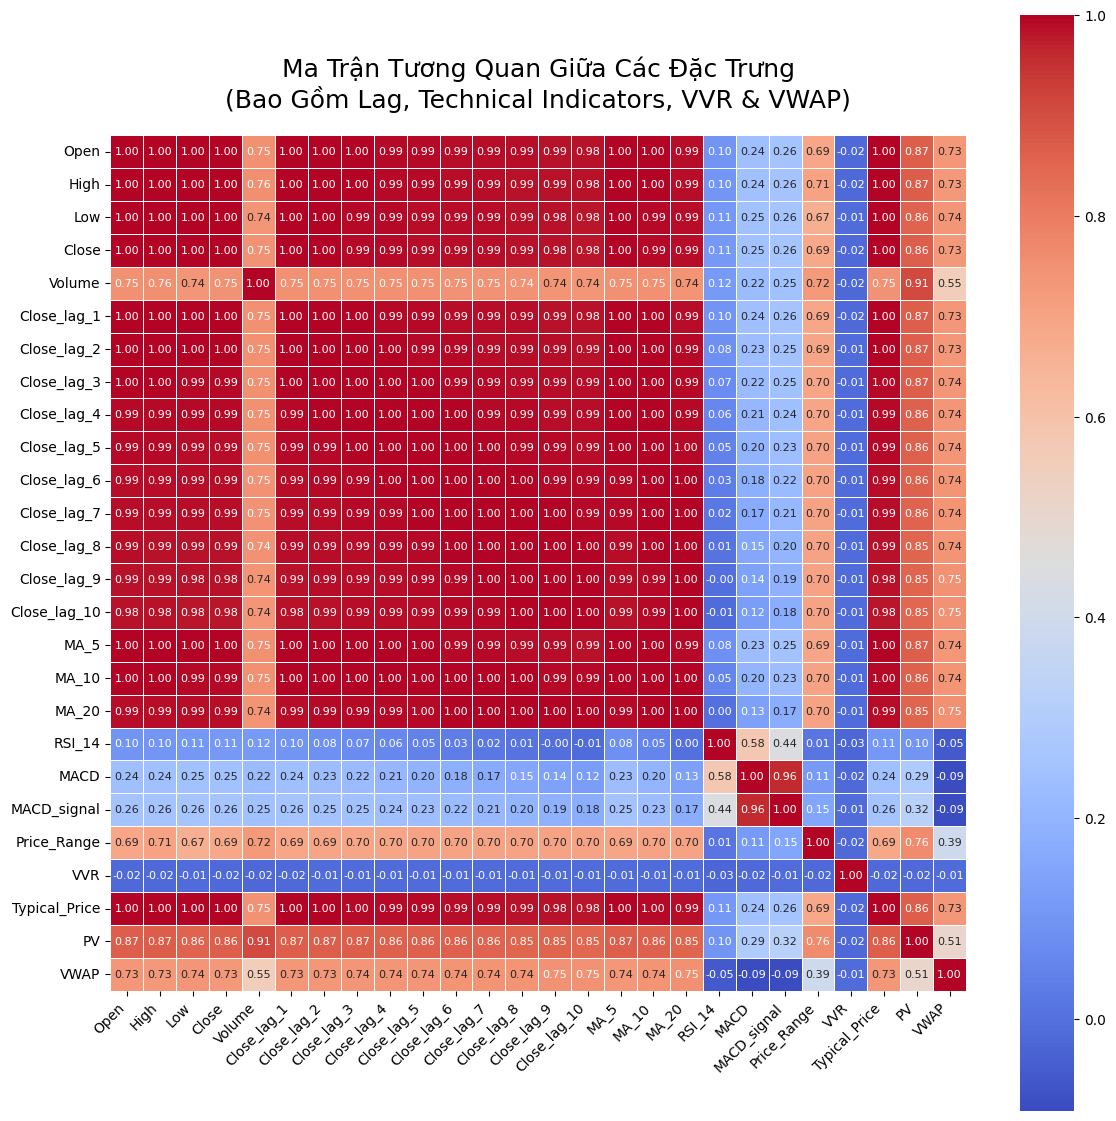

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


# Tạo features mới theo paper (nếu chưa tạo)
features_base = ['Open', 'High', 'Low', 'Close', 'Volume']
df = df[features_base + ['Date']].copy() 

# Lag features (Close lag 1-10)
lag_days = 10
for i in range(1, lag_days + 1):
    df[f'Close_lag_{i}'] = df['Close'].shift(i)

# Technical indicators
df['MA_5'] = df['Close'].rolling(window=5).mean()
df['MA_10'] = df['Close'].rolling(window=10).mean()
df['MA_20'] = df['Close'].rolling(window=20).mean()

# RSI 14
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI_14'] = 100 - (100 / (1 + rs))

# MACD
ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# Liquidity proxies
epsilon = 1e-8
df['Price_Range'] = df['High'] - df['Low']
df['VVR'] = df['Volume'] / (df['Price_Range'] + epsilon)

df['Typical_Price'] = (df['High'] + df['Low'] + df['Close']) / 3
df['PV'] = df['Typical_Price'] * df['Volume']
df['VWAP'] = df['PV'].cumsum() / df['Volume'].cumsum()  # Cumulative VWAP cho daily data

# Xóa NaN
df_clean = df.dropna().reset_index(drop=True)

# ===== VẼ MA TRẬN TƯƠNG QUAN =====
corr_features = [col for col in df_clean.columns if col != 'Date']  # Loại Date
corr = df_clean[corr_features].corr()

plt.figure(figsize=(12, 14))  # Kích thước lớn để đọc dễ với nhiều features
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, 
            square=True, cbar_kws={"shrink": .8}, annot_kws={"size": 8})

plt.title('Ma Trận Tương Quan Giữa Các Đặc Trưng\n(Bao Gồm Lag, Technical Indicators, VVR & VWAP)', 
          fontsize=18, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()  